# initialisation 

In [2]:
# imports 
import pandas as pd
import ipywidgets as widgets


# databases 
airports_df = pd.read_csv("../data/aeroportsANLO.csv")
routes_df = pd.read_csv("../data/routesANLO.csv")
continents_df = pd.read_csv("../data/countries.csv")

# conversion to dict continent 
continents_dict = dict(zip(continents_df['country'], continents_df['continent'])); del continents_df
airports_df


,Name,Iata,Icao,Lat,Lon,Country,Alt,City
0,A Coruna Airport,LCG,LECO,43.302059,-8.377250,Spain,326,La Coruna
1,Aachen Merzbruck Airport,AAH,EDKA,50.823051,6.186111,Germany,623,Aachen
2,Aalborg Airport,AAL,EKYT,57.092781,9.849164,Denmark,10,Aalborg
3,Aarhus Airport,AAR,EKAH,56.300011,10.619000,Denmark,82,Aarhus
4,Aarhus Sea Airport,QEA,EKAC,56.151993,10.247725,Denmark,1,NaN
...,...,...,...,...,...,...,...,...
4630,Zunyi Xinzhou Airport,ZYI,ZUZY,27.811167,107.245972,China,2723,Zunyi
4631,Zurich Airport,ZRH,LSZH,47.464722,8.549167,Switzerland,1416,Zurich
4632,Zwara Airport,WAX,HLZW,32.933334,12.083333,Libya,9,NaN
4633,Zweibrucken Airport,ZQW,EDRZ,49.209518,7.400647,Germany,1133,Zweibruecken


In [3]:
# TODO doit etre possible plus vite 
airports_dict = dict()
for row in airports_df[['Iata','Name','Country']].iterrows():
    a = row[1][0]
    b = row[1][1]
    c = row[1][2]
    airports_dict[a] = dict(zip(['Name','Country'], [b,c]))


In [4]:
# optie 1 
r1 = routes_df[routes_df['Depart'] == 'KWE'][['Arrivee', 'Num_IATA']]
r2 = routes_df[routes_df['Arrivee'] == 'AMS'][['Depart', 'Num_IATA']]
pd.merge(r1, r2,left_on = 'Arrivee', right_on = 'Depart')

,Arrivee,Num_IATA_x,Depart,Num_IATA_y
0,CAN,AQ1028,CAN,CZ2577
1,CAN,AQ1028,CAN,CZ455
2,CAN,AQ1028,CAN,CZ307
3,CAN,AQ1028,CAN,CZ2573
4,CAN,CZ6394,CAN,CZ2577
...,...,...,...,...
121,XMN,SC8770,XMN,MF811
122,XMN,MF8438,XMN,MF811
123,XMN,GS6461,XMN,MF811
124,XMN,AQ1641,XMN,MF811


In [5]:
# optie 2
def correspondance_1airport_int(code1 : str, code2 : str):
    r1 = routes_df[routes_df['Depart'] == code1]['Arrivee'].to_list()
    r2 = routes_df[routes_df['Arrivee'] == code2]['Depart'].to_list()

    return list(set(r1).intersection(r2))

print(correspondance_1airport_int('KWE', 'AMS')) # ['PVG', 'XMN', 'NKG', 'CAN', 'PEK']

['NKG', 'XMN', 'CAN', 'PVG', 'PEK']


In [113]:
graph_test_nb = { # form needed for dijkstra
    0: [(1, 5), (2, 1)],
    1: [(0, 5), (3, 2)],
    2: [(0, 1), (3, 1)],
    3: [(1, 4), (2, 1)]
}
print(type(graph_test_nb))

graph_test_names = {
    'AAL': [('LPA', 5), ('DUS', 1)],
    'LPA': [('AAL', 5), ('LNZ', 2)],
    'DUS': [('AAL', 1), ('LNZ', 1)],
    'LNZ': [('LPA', 4), ('DUS', 1)],   
}

<class 'dict'>


## premiere essay graphes 

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
graph = dict()
#def creation_graph(begin, intermediaire, end):

#creation node 0: 
#creation tuple (direction, weight)
    
    

In [20]:
# creating edges 
def creation_edges_v1(graph : dict): 
    '''
    function qui crée des edges pour le graphe 
    retour list des tuples (start, end, weight)
    '''
    edges = []

    for i in range(0,4) : 
        #print(graph_test_nb[i])
        for j in range (0, len(graph[i])):
            edges.append((i, graph[i][j][0], graph[i][j][1]))
    return edges         

e = creation_edges(graph_test_nb)
print(e)

[(0, 1, 5), (0, 2, 1), (1, 0, 5), (1, 3, 2), (2, 0, 1), (2, 3, 1), (3, 1, 4), (3, 2, 1)]


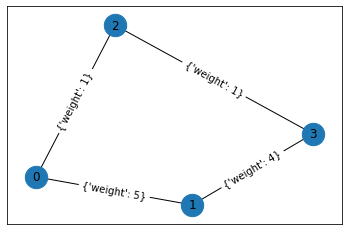

In [9]:
G = nx.Graph()

G.add_weighted_edges_from(e)
#circular_layout , spring_layout
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 500)
nx.draw_networkx_edges(G,pos, edgelist= G.edges(), edge_color='black')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos)

plt.show()

##  Graphe airports

In [40]:
# besoin d'une grande list qui rappel tous chiffre avec les codes des airports  
def creation_edges(listConnections, graphe, listReference, code1, code2, returnListEdges):
    # dans le listReference les airport recois un index qui corresponds au identifiant de graphe 
    
    listReference.append(code1); #  airport de depart 
    index1 = listReference.index(code1); 
    
    for i in listConnections :
        listReference.append(i)     
    
    listReference.append(code2); # fin list => airport de  arrivee
    index2 = listReference.index(code2)
    
    listEdges = []
    for i in listConnections : 
        weight = 2 # TODO doit etre remplacee par CO2
        
        indextmp = listReference.index(i)
        listEdges.append((index1, indextmp , weight))
        listEdges.append((indextmp,index2, weight))
    
    graphe.add_weighted_edges_from(listEdges)
    returnListEdges.extend(listEdges)
    return listReference

In [22]:
def dessiner_graphe(nom_graphe, code1, code2):
 #spring_layout, shell_layout
    pos = nx.fruchterman_reingold_layout(nom_graphe)
    nx.draw_networkx_nodes(nom_graphe, pos, node_size = 200)
    nx.draw_networkx_edges(nom_graphe,pos, edgelist= nom_graphe.edges(), edge_color='black')
    nx.draw_networkx_labels(nom_graphe, pos)
    plt.autoscale()
    plt.title((code1,code2))
    #nx.draw_networkx_edge_labels(nom_graphe, pos) # afficher le weight 

    plt.show()

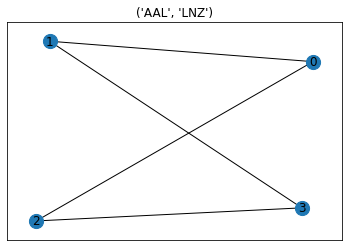

In [127]:
# werkt voor 'AAL' naar 'LNZ'
list1 = correspondance_1airport_int('AAL', 'LNZ')
graphe_test = nx.Graph()
zz = []
creation_edges(list1, graphe_test, [], 'AAL', 'LNZ', zz)
dessiner_graphe(graphe_test, 'AAL', 'LNZ')


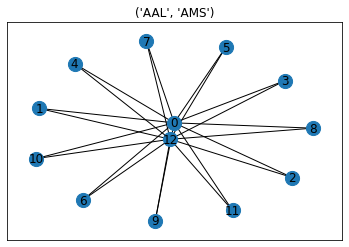

weighted edges : 
[(0, 1, 2), (1, 12, 2), (0, 2, 2), (2, 12, 2), (0, 3, 2), (3, 12, 2), (0, 4, 2), (4, 12, 2), (0, 5, 2), (5, 12, 2), (0, 6, 2), (6, 12, 2), (0, 7, 2), (7, 12, 2), (0, 8, 2), (8, 12, 2), (0, 9, 2), (9, 12, 2), (0, 10, 2), (10, 12, 2), (0, 11, 2), (11, 12, 2)]
edges coordinaat : 


[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (1, 12),
 (12, 2),
 (12, 3),
 (12, 4),
 (12, 5),
 (12, 6),
 (12, 7),
 (12, 8),
 (12, 9),
 (12, 10),
 (12, 11)]

In [90]:
# test 2 'LYS' 'AMS'
graphe_test2 = nx.Graph()
rList = []
rr = creation_edges(correspondance_1airport_int('AAL', 'AMS'), graphe_test2, [], 'AAL', 'AMS', rList)

dessiner_graphe(graphe_test2,'AAL', 'AMS')

# all the edges
print("weighted edges : ")
print(rList) 
print("edges coordinaat : ")
conversion_test = [e for e in graphe_test2.edges] # list of edges 
[e for e in graphe_test2.edges] # list of nodes 
#graphe_test2.number_of_edges() # number of edges 
#graphe_test2.number_of_nodes() # number of edges 



In [104]:
# sort list of tuples 

rList.sort(key= lambda a : a[0])
print(rList)

[(0, 1, 2), (0, 2, 2), (0, 3, 2), (0, 4, 2), (0, 5, 2), (0, 6, 2), (0, 7, 2), (0, 8, 2), (0, 9, 2), (0, 10, 2), (0, 11, 2), (1, 12, 2), (2, 12, 2), (3, 12, 2), (4, 12, 2), (5, 12, 2), (6, 12, 2), (7, 12, 2), (8, 12, 2), (9, 12, 2), (10, 12, 2), (11, 12, 2)]


In [138]:
def conversion(listOfEdgesWeighted, graphe):
    '''
        function qui convertie un list avec les edges d'uin graph avec leur "weight" et 
        qui le convertie en une dict de graph qui peut être utilise par le algorithme de dijkstra 
        retour : le dict qui represente une graphe sous forme de { 0 : [(end, weight) , (end, weight)], 1 : [ ..] etc }
    '''
    # calculer le nombre de nodes 
    nbNodes = graphe.number_of_nodes()
  
    # creation d'une dict avec le nombre de nodes initialise avec une liste vide 
    returnDict= dict()
    for i in range(0, nbNodes): 
        returnDict[i] = []
    
    # remplir le dictionairy a partir de listOfEdgesWeighted
    for t in listOfEdgesWeighted:
        # on doit ajoute les edges dans les deux cote (de 1 --> 2 et de 2 --> 1)
        returnDict[t[0]].append((t[1],t[2])) 
        returnDict[t[1]].append((t[0],t[2])) 
    return returnDict

In [135]:

zie1 = conversion(rList, graphe_test2)
zie2 = conversion(zz, graphe_test)
print(zie2)
   
print(graph_test_nb)

{0: [(1, 2), (2, 2)], 1: [(0, 2), (3, 2)], 2: [(0, 2), (3, 2)], 3: [(1, 2), (2, 2)]}
{0: [(1, 5), (2, 1)], 1: [(0, 5), (3, 2)], 2: [(0, 1), (3, 1)], 3: [(1, 4), (2, 1)]}


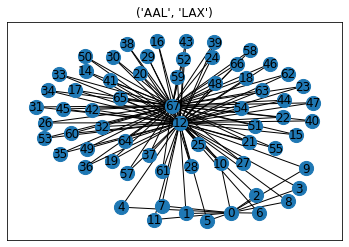

In [27]:
# test 3 
graphe_test3 = nx.Graph()

list_test3 = creation_edges(correspondance_1airport_int('AAL', 'AMS'), graphe_test3, [], 'AAL', 'AMS')
# si on reutilise le list_test3 on peu aggrandir notre carte, et du coup ajoute des correspondances 
list_resultat = creation_edges(correspondance_1airport_int('AMS', 'LAX'), graphe_test3, list_test3, 'AMS', 'LAX')

dessiner_graphe(graphe_test3,'AAL', 'LAX')
# on peut recupere le nom d'une airport intermediare par appele
#list_resultat[2]

## Dijkstra algorithme try 1 
inspiration from https://pythonalgos.com/dijkstras-algorithm-in-5-steps-with-python/
number node => code_airport , 
distance => ecoprint 

#
https://coderzcolumn.com/tutorials/data-science/network-analysis-in-python-node-importance-and-paths-networkx#4.1

In [13]:
from numpy import Inf
import heapq

In [14]:
def lazy_dijkstras(graph, root):
    n = len(graph)
    # set up "inf" distances
    dist = [Inf for _ in range(n)]
    # set up root distance
    dist[root] = 0
    # set up visited node list
    visited = [False for _ in range(n)]
    # set up priority queue
    pq = [(0, root)]
    # while there are nodes to process
    while len(pq) > 0:
        # get the root, discard current distance
        _, u = heapq.heappop(pq)
        # if the node is visited, skip
        if visited[u]:
            continue
        # set the node to visited
        visited[u] = True
        # check the distance and node and distance
        for v, l in graph[u]:
            # if the current node's distance + distance to the node we're visiting
            # is less than the distance of the node we're visiting on file
            # replace that distance and push the node we're visiting into the priority queue
            if dist[u] + l < dist[v]:
                dist[v] = dist[u] + l
                heapq.heappush(pq, (dist[v], v))
    return dist

In [15]:
#print(naive_dijkstras(graph,1))
lazy_dijkstras(graph_test_nb, 0) #[0, 5, 1, 2]

# cela veut dire que 
#    | AAL|LPA |DUS |LNZ|
# AAL  0  |  5 | 1  | 2 |
# conclusion de AAL à LNZ le plus courte chemin est 2

[0, 5, 1, 2]